<a href="https://colab.research.google.com/github/brunokrp/ai-protectionism/blob/main/ai_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

A country has at its disposal a variety of policy instruments to incentivize local development, reduce foreign influence and regulate the internal use of technology. The industrial policy literature has mapped an extensive list of policies that can be used to target the transformation of the structure of economic activity in pursuit of some goal, encompassing domains such as “selective industry support”, “economic signals and incentives” and “distribution of information”.

As with public policy in general, the use of those instruments is largely dependent on the institutional context of the state deploying them, and should be developed and deployed as a reflection of a country’s political, economic and technological environments. It is also expected that different instruments should be used with specific goals in mind. For countries at a technology’s frontier, for example, investment in public R&D, protection of intellectual property laws and international cooperation are better tools. For countries trying to catch-up, tax incentives, international mobility and adoption incentives should better fit their situation.

Since the position of a country in the “AI race” should influence the policies adopted to foster and regulate the AI sector worldwide, it becomes necessary to identify where each country is in the “AI race” and the political-economic conditions it currently faces. With those features in mind, a clustering algorithm was used to group similar countries according to the following metrics:

1. The level of AI development - Talent, Research, Development, and Commercial indexes, Tortoise’s AI Global Index, 2023;
2. The openness to AI consumption - Infrastructure and Operating Conditions indexes, Tortoise’s AI Global Index, 2023;
3. The size of the population - Total Population, World Bank, 2023;
4. The size of the internal market - Households and NPISHs Final consumption expenditure (current US$), World Bank, 2023;
5. The level of fiscal restriction - General government debt (% of GDP), IMF, 2023
6. The level of national investment - Gross capital formation (% of GDP), World Bank, 2023

**By using those six main indicators, it is possible to group similar countries. Using a k-means clustering algorithm and the elbow method to define the optimal number of clusters, five main clusters were found, which are highlighted below.**

# **CODING**

## **ENVIRONMENT**

In [1]:
!pip install kneed --quiet
!pip install mpld3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from google.colab import files
import numpy as np
import gspread
import csv
import geopandas
import folium
from shapely.geometry import Point, Polygon
from folium.plugins import HeatMap
import seaborn as sns

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

import mpld3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"/"ai_clusters"

/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT/ai_clusters


## **DATASET**

In [59]:
df_original = pd.read_csv("country_clustering_data.csv", decimal=".")
df_original.head()

,Country,Talent,Infrastructure,Operating Environment,Research,Development,Government Strategy,Commercial,Total score,Region,Cluster,Income group,Political regime,General Government Debt,Central Government Debt,Democracy Index,Government Expenditure,Gross Capital Formation,Household Expenditure,Population
0,Argentina,8.40,56.15,75.95,1.25,3.19,54.94,0.34,15.24,Americas,Waking up,Upper middle,Electoral democracy,155.411034,155.411034,6.62,16.387469,19.371539,5.050069e+11,45538401.0
1,Armenia,6.69,37.84,58.40,0.28,0.33,14.40,1.37,8.49,Europe,Waking up,Upper middle,Electoral democracy,50.723130,50.723130,5.42,14.146579,21.295373,1.248698e+10,2990900.0
2,Australia,25.43,63.43,61.23,32.63,41.15,82.11,6.72,33.86,Asia-Pacific,Rising stars,High,Liberal democracy,49.008847,34.832823,8.66,21.313855,23.974017,1.287748e+12,26658948.0
3,Austria,16.97,64.49,76.30,23.56,17.81,72.14,3.08,26.89,Europe,Waking up,High,Electoral democracy,77.544998,59.181436,8.28,20.465413,25.408015,2.966402e+11,9131761.0
4,Bahrain,4.99,60.39,60.90,2.53,0.00,17.72,0.24,11.79,Middle East,Waking up,High,Closed autocracy,123.320290,123.320290,2.52,14.649346,28.992966,2.343077e+10,1577059.0


## **FEATURE ENGINEERING**

In [60]:
# Creating dataset copy
df_all = df_original.copy()

# Creating new columns
df_all["consumer_potential"] = df_all["Infrastructure"] + df_all["Operating Environment"]
df_all["development_potential"] = df_all["Talent"] + df_all["Research"] + df_all["Development"] + df_all["Commercial"]

# Dropping India, China and USA
df = df_all.drop(index=[9,22,59])

In [61]:
# Creating function to normalize data
def normalize_columns(df, columns, scale_factor=100):

    for column in columns:
        scaler = MinMaxScaler()
        reshaped_values = df[column].values.reshape(-1, 1)
        scaler.fit(reshaped_values)
        normalized_column_name = f"{column}_norm"
        df[normalized_column_name] = scaler.transform(reshaped_values) * scale_factor
    return df

columns_to_normalize = ['consumer_potential', 'development_potential', 'General Government Debt', 'Central Government Debt', 'Democracy Index',
       'Government Expenditure', 'Gross Capital Formation', 'Household Expenditure', 'Population']

# Applying function to dataset
df = normalize_columns(df, columns_to_normalize)

In [62]:
# Creating dataframe including only relevant data
df_clustering = df[[
                    'Country', 'consumer_potential','development_potential',
                    'consumer_potential_norm',
                    'development_potential_norm',
                    'General Government Debt_norm',
                    #'Democracy Index_norm',
                    #'Government Expenditure_norm',
                    'Gross Capital Formation_norm',
                    'Household Expenditure_norm',
                    'Population_norm'
                    ]]

# Dropping rows with null values
df_clustering = df_clustering.dropna(axis=0)

## **CLUSTERING**

### **DEFINING NUMBER OF CLUSTERS**

#### **Elbow method**

In [63]:
# Defining arguments for clustering
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
   }

# Defining arguments for clustering
sse = []
slice_columns = (df_clustering.shape[1]-3)*(-1)

for k in range(1, 20):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(df_clustering.iloc[:,slice_columns:])
  sse.append(kmeans.inertia_)

kl = KneeLocator(
  range(1, 20), sse, curve="convex", direction="decreasing")

print(f'Optimal number of clusters: {kl.elbow}')

Optimal number of clusters: 5


#### **Silhouette method**

In [64]:
silhouette_coefficients = []

for k in range(2, 20):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(df_clustering.iloc[:,slice_columns:])
  score = silhouette_score(df_clustering.iloc[:,slice_columns:], kmeans.labels_)
  silhouette_coefficients.append(score)

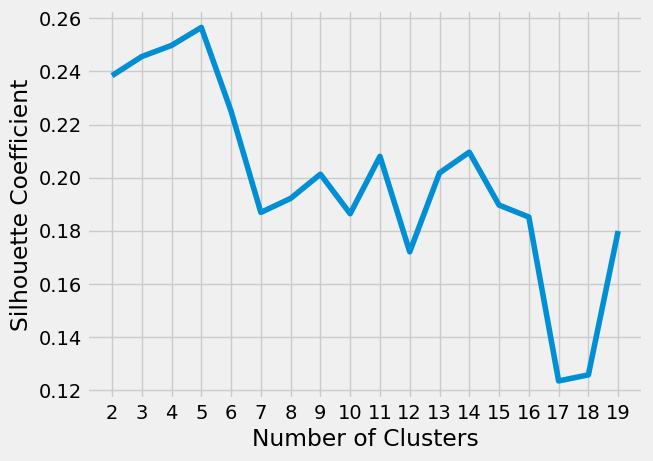

In [65]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### **KMEANS CLUSTERING**

In [66]:
# Defining parameters
kmeans_final = KMeans(
  init="random",
  n_clusters=kl.elbow,
  n_init=10,
  max_iter=300,
  random_state=42,
)

# Fitting data
kmeans_final.fit(df_clustering.iloc[:,slice_columns:])

# Getting labels
df_clustering["cluster_kmean"] = kmeans_final.labels_

# Creating dataframe with average value for each cluster
df_cluster_results = pd.DataFrame(kmeans_final.cluster_centers_)
df_cluster_results = df_cluster_results.rename(columns={
  0 : 'consumer_potential_norm',
  1 : 'development_potential_norm',
  2 : 'general_government_debt_norm',
  3 : 'gross_capital_formation_norm',
  4 : 'household_expenditure_norm',
  5 : 'population_norm'
  })

df_cluster_results

,consumer_potential_norm,development_potential_norm,general_government_debt_norm,gross_capital_formation_norm,household_expenditure_norm,population_norm
0,11.312575,4.188746,27.260052,8.173239,8.548187,49.406943
1,84.304345,61.014383,16.854676,60.349859,12.428291,5.073196
2,87.811806,70.160092,46.930977,49.940454,67.631180,26.185330
3,72.607870,12.466451,23.716294,45.196399,4.405550,6.266024
4,63.796344,13.652676,9.517584,70.599551,28.820116,56.340565


## **CREATING COMPLETE DATAFRAME (with USA, China and India)**

In [67]:
# Selecting only relevant data from clustering dataframe
df_clusters = df_clustering[['Country', 'consumer_potential','development_potential','cluster_kmean']]

# Selecting data from US, China and India
df_giants = df_all.iloc[[9,22,59],:][['Country', 'consumer_potential','development_potential']]

# Concatenating dataframes and manually inputing values for US, China and India
df_clusters = pd.concat([df_clusters, df_giants])
df_clusters.loc[9, 'cluster_kmean'] = 5
df_clusters.loc[22, 'cluster_kmean'] = 6
df_clusters.loc[59, 'cluster_kmean'] = 7

In [68]:
# Replacing names of countries to match data from other organizations
country_dict = {
  'Slovak Republic' : 'Slovakia',
  'Korea, Rep.' : 'Republic of Korea',
  'Turkey' : 'Turkyie',
  'United States' : 'United States of America'
}

df_clusters['Country'] = df_clusters['Country'].replace(country_dict)

## **VISUALIZING COUNTRIES**

In [77]:
# Plotting countries without US, China and India
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(df_clusters["development_potential_norm"],
                     df_clusters["consumer_potential_norm"],
                     c=df_clusters["cluster_kmean"],
                     alpha=0.8,
                     s=df_clusters["Population_norm"],
                     cmap=plt.cm.jet
                     )

ax.set_title("AI SCENARIO", size=12)
ax.set_xlabel('AI DEVELOPMENT POTENTIAL', size=12)
ax.set_ylabel('AI CONSUMPTION POTENTIAL', size=12)

labels = ['{0}'.format(i) for i in df_clustering["Country"]]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

/usr/local/lib/python3.10/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.10/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.10/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.10/dist-packages/mpld3/mplexporter/utils.py:300: M

## **Exporting dataframe to csv for future research**

In [70]:
df_clusters.to_csv("ai_clusters_countries.csv")